# Matrix Factorization(MF)

- 사용자와 아이템을 추상화된 동일한 특질(latent factor)을 이용하여 표현
- Rating matrics 구조를 표현하는데 SVD(Singular Value Decomposition)으로 user,item profile vector로 표현하여 rating을 예측하는 방법

<img width='1000' src='img/MF/MF기본구조.png'>


### Matrix Factorization: Rank - k 로 일반화

- 위 예시는 one rank 이지만 K개 차원으로 U,V를 각각 표현 가능

<img width='1000' src='img/MF/MFRank_K.png'>

# 1. MF 다양한 학습 방법론

## SVD(Singular Value Decomposition)
<img width='800' src='img/MF/incompleteSVD.png'>

## Regularized SVD
<img width='800' src='img/MF/regularizedSVD.png'>

- 기존 SVD 함수에 규제를 적용한 방식으로 앞으로 기본적으로 적용되고 생략되어 설명된다

## Regularized SVD by Gradient Descent
<img width='800' src='img/MF/Regularized SVD by Gradient Descent.png'>

- U or V를 상수로 두고 Gradient Descent를 적용하여 업데이트
- 단점 속도가 느림

## Reqularized SVD by Alternating Least
<img width='800' src='img/MF/ALS_1.png'>
<img width='800' src='img/MF/ALS_2.png'>

- U or V 중 하나를 고정하고 linear regression방식으로 푸는 방식
- 모두 학습 대상 변수 (unknown variable): non-convex
- 둘 중 한 변수는 정해져 있다고 가정하면, quadratic problem (convex)
- 초기 임의의 값으로 U,V 중 하나를 설정하고 U,V가 수렴할 때까지 업데이트
- 초기 설정값에 따라 학습결과가 달라지지만 학습 속독 빠름

## Reqularized SVD: Bias Terms
<img width='800' src='img/MF/SVDBias.png'>

- 사용자와 아이템마다 평점 분포가 다르기 때문에 r를 단순히 U*V로 기술하는데 한계가 있음
- bias 항을 추가하여 표현하자
- 모든 평점의 평균(b)을 더해주는 이유는 대부분의 아이템이 평균적으로 b(μ) 정도의 값은 받는다는 것을 감안해주기 위함이다.

- b: 전체평점평균
- bi: 아이템i의평점편차
- bu: 사용자u의평점편차
- [링크참조](https://sungkee-book.tistory.com/12)

## SVD++
<img width='800' src='img/MF/SVD++.png'>

# 2. Matrix Factorization 장단점

장점
- 별점 예측이(메모리 기반 방식보다) 정확함
- 모델 기반 방식이라 일단 한번 학습만 끝나면 예측이 빠름

단점
- 학습시 많은 computing resource가 요구됨(1회성으로 큰 부담 안되는 경우가 많다)
- 추천하는 이유를 설명하기 어려움(가장 큰 단점)


# 3. SGD 이용한 regularization MF 실습
- Train matrix factorization from scratch
- Matrix Factorization 코드는 [github](https://github.com/albertauyeung/matrix-factorization-in-python/blob/master/mf.py)을 참고했습니다.
- SGD를 사용한 matrix factorization 기법


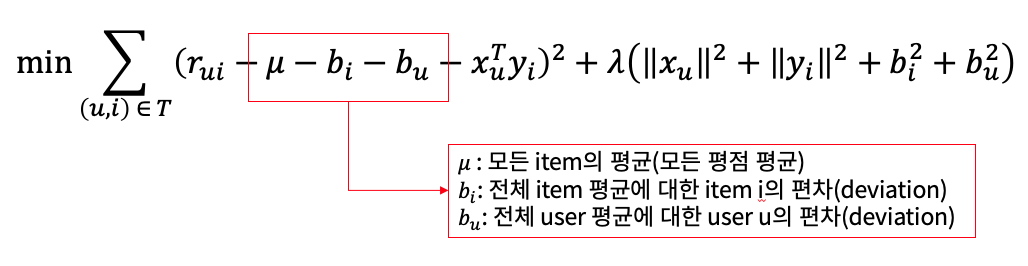

## Load Dataset

In [1]:
import os
import pandas as pd
import numpy as np
from math import sqrt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [4]:
# 각자 작업 환경에 맞는 경로를 지정해주세요. Google Colab과 Jupyter환경에서 경로가 다를 수 있습니다.
ratings_df = pd.read_csv(os.path.join('data/movielens/', 'ratings.csv'), encoding='utf-8')

print(ratings_df.shape)
print(ratings_df.head())

(100004, 4)
   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205


In [45]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape)
print(test_df.shape)

(80003, 4)
(20001, 4)


In [38]:
# train_df = train_df[:1000]

In [46]:
sparse_matrix = train_df.groupby('movieId').apply(lambda x: pd.Series(x['rating'].values, index=x['userId'])).unstack()
sparse_matrix.index.name = 'movieId'

sparse_matrix = sparse_matrix.fillna(0)

# fill sparse matrix with average of movie ratings
sparse_matrix_withmovie = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

# # fill sparse matrix with average of user ratings
# sparse_matrix_withuser = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

In [47]:
sparse_matrix = sparse_matrix.to_numpy()
sparse_matrix_withmovie = sparse_matrix_withmovie.to_numpy()
sparse_matrix

array([[0., 0., 0., ..., 0., 4., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
class MF():
    
    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.
        
        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """
        
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            # if (i+1) % 10 == 0:
            print("Iteration: %d ; error = %.4f" % (i+1, mse))
        
        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)
            
            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])
            
            # Create copy of row of P since we need to update it but use older values for update on Q
            # P_i = self.P[i, :][:] 위 코드를 쓰게되면 nan sparse한 데이터일 경우 nan값 출력됩니다
            P_i = np.ndarray.copy(self.P[i,:])
            
            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * P_i - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [48]:
mf = MF(sparse_matrix, K=150, alpha=0.1, beta=0.01, iterations=20)

In [49]:
training_process = mf.train()

Iteration: 1 ; error = 247.5634
Iteration: 2 ; error = 229.5728
Iteration: 3 ; error = 180.9479
Iteration: 4 ; error = 123.2385
Iteration: 5 ; error = 82.9672
Iteration: 6 ; error = 57.8620
Iteration: 7 ; error = 41.4579
Iteration: 8 ; error = 32.5679
Iteration: 9 ; error = 27.2732
Iteration: 10 ; error = 24.0650
Iteration: 11 ; error = 22.1827
Iteration: 12 ; error = 20.8899
Iteration: 13 ; error = 20.5521
Iteration: 14 ; error = 20.2004
Iteration: 15 ; error = 19.5278
Iteration: 16 ; error = 19.3970
Iteration: 17 ; error = 18.7900
Iteration: 18 ; error = 18.9877
Iteration: 19 ; error = 19.0730
Iteration: 20 ; error = 18.7613


In [50]:
mf.full_matrix()

array([[2.44909377, 3.64707848, 3.31556436, ..., 3.93914934, 3.99022575,
        4.61416927],
       [2.10185713, 3.12017594, 3.47702194, ..., 2.99096859, 3.97641519,
        2.97115447],
       [2.49787968, 3.92589706, 3.46821943, ..., 2.36916292, 3.2457936 ,
        2.59360204],
       ...,
       [3.07349854, 4.14004795, 4.30673298, ..., 4.06972821, 4.32118348,
        4.25036647],
       [2.00697531, 3.16384846, 3.1896679 , ..., 3.16600651, 3.14664232,
        3.3178045 ],
       [2.60226847, 3.72898343, 4.11584865, ..., 3.99681366, 4.05855477,
        4.11068909]])

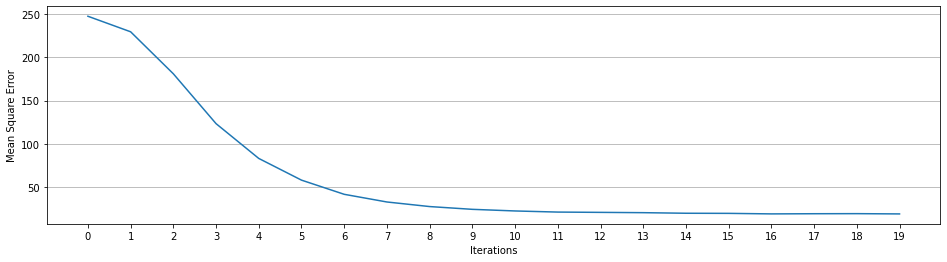

In [51]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")